In [1]:
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error

## ローレンツ96のモデルを作る
6h = 0.05 step

In [2]:
def l96_model(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

def l96_6h(x, step):
    t = np.arange(0.0, step, 0.01)
    x = odeint(l96_model, x, t)
    return x

In [3]:
N = 40
F = 8
step = 0.05
x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable

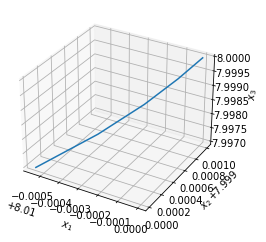

In [4]:
x = l96_6h(x0, step)

# Plot the first three variables
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()


### 2年分の積分
2 * 365 * 4 * 0.05 = 146.0 step必要

In [5]:
x_one = l96_6h(x0, 73.0)  # spin up
x = l96_6h(x_one[-1], 73.0)
data = x[::5]

In [6]:
np.savetxt("gendata.txt", data)

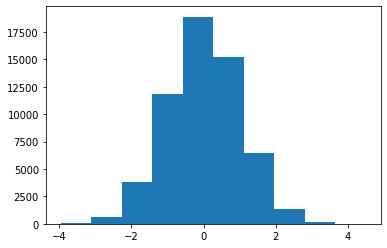

In [7]:
random_ls = np.random.randn(data.shape[0], x[::5].shape[1])
plt.hist(np.ravel(random_ls))
plt.show()

In [8]:
datawithnoise = data + random_ls
np.savetxt("datawithnoise.txt", datawithnoise)

## データ同化システムの構築
カルマンフィルタ

In [20]:
# 初期値
pa = np.eye(N) * 25
pf = np.eye(N) * 25
rs = step * int(np.random.randint(1, 1000))
xa = l96_6h(x_one[-1], rs)[-1]
xf = xa

In [21]:
def kf_forecast(xa, pa):
    R = np.eye(N)
    H = np.eye(N)
    step = 0.05
    def getM(xc):
        m = []
        delta = 0.0001
        for i in range(xc.shape[0]):
            b = np.zeros_like(xc)
            b[i] += delta
            m.append(l96_6h(xc + b, step)[-1] - l96_6h(xc, step)[-1])
        return np.array(m).T /delta
    M = getM(xa)
    xf = l96_6h(xa, step)
    pf = M @ pa @ M.T
    return xf[-1], pf

In [ ]:
xferror_before_assim =[]
xferror_after_assim = []
trpa = []
yrmse = []
for  i in tqdm(range(300)):
    if i % 100 == 0:
        print(i)
    yt = data[i]
    y = datawithnoise[i]
    xferror_before_assim.append( np.sqrt(mean_squared_error(yt,  xf)))
    K = pf @ H.T @ np.linalg.inv(H@ pf @ H.T + R)
    xa = xf + K @ (y - H @ xf)
    pa = pf - K @ H @ pf
    xf, pf = kf_forecast(xa, pa)
    xferror_after_assim.append( np.sqrt(mean_squared_error(yt,  xf)))
    yrmse.append( np.sqrt(mean_squared_error(yt,  y)))
    trpa.append(np.trace(pa))

0


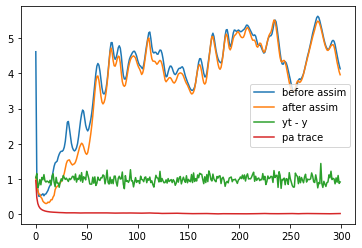

In [19]:
plt.plot(xferror_before_assim, label="before assim")
plt.plot(xferror_after_assim, label="after assim")
plt.plot(yrmse, label="yt - y")
plt.plot(np.array(trpa) / N, label="pa trace")
plt.legend()
plt.show()

In [13]:
trpa

[38.461538461538396,
 18.83669203335443,
 12.347299122968217,
 9.19548557289602,
 7.360713737434399,
 6.169599683046821,
 5.33577588215094,
 4.7155662315031845,
 4.2440486607271595,
 3.8670846689295564,
 3.5645035517207107,
 3.3164975702768076,
 3.1141229428394688,
 2.9465659983682,
 2.7984381751986662,
 2.6719820943904624,
 2.5757900292727176,
 2.5151204083037175,
 2.4785788133412012,
 2.4318897596259346,
 2.354656544686067,
 2.2535460812652865,
 2.158635468390442,
 2.1090599291743217,
 2.097296933017808,
 2.0825357695303506,
 2.0342816263076724,
 1.955509124246308,
 1.870738547307924,
 1.80493491786179,
 1.7772680119901931,
 1.7883695627750655,
 1.8155849580967627,
 1.82339757134532,
 1.8281895638221561,
 1.847488070680912,
 1.848249076936439,
 1.8295198178723584,
 1.7980407411339039,
 1.7472050677342486,
 1.6800314562862955,
 1.615509293154412,
 1.5757053236420229,
 1.5775126160999449,
 1.6173092577317838,
 1.6637250121009566,
 1.6858312635283246,
 1.6936404769018891,
 1.69746371629